In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import plotly 
import plotly.express as px


import plotly.graph_objects as go # or plotly.express as px
#fig = go.Figure() # or any Plotly Express function e.g. px.bar(...)
# fig.add_trace( ... )
# fig.update_layout( ... )

import dash
import dash_core_components as dcc
import dash_html_components as html



#### Question 1-2

In [21]:
df = pd.read_csv('gapminder_clean.csv', index_col=[0])

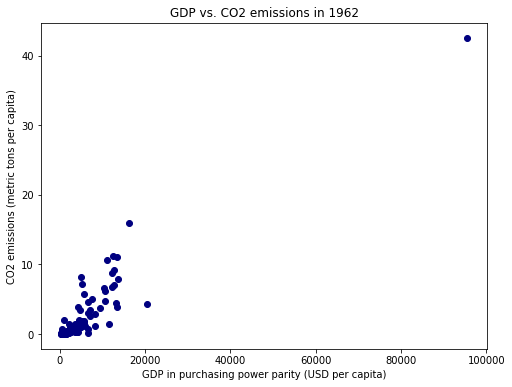

In [22]:
df62 = df.loc[np.where((df['Year'] == 1962))] 
# Filter data to include rows where year is 1962
co2 = df62['CO2 emissions (metric tons per capita)']
gdp = df62['gdpPercap']
plt.figure(figsize=(8, 6))
plt.scatter((gdp), (co2), c='navy')
plt.ylabel('CO2 emissions (metric tons per capita)')
plt.xlabel('GDP in purchasing power parity (USD per capita)')
plt.title('GDP vs. CO2 emissions in 1962')
plt.show()

After visualizing the original data, we see that there are some large values that are far from most of the smaller values which appear clustered/close to each other. It appears as a GPD per capita increases, CO2 emissions increases at a faster rate, up until the GDP per capital is at about 200,000. We cannot determine if the relationship between the x and y values are linear by just visualizing them. 

However, given that the order of magnitude of both x and y values are large, we log transform both x (GDP) and y values (CO2).

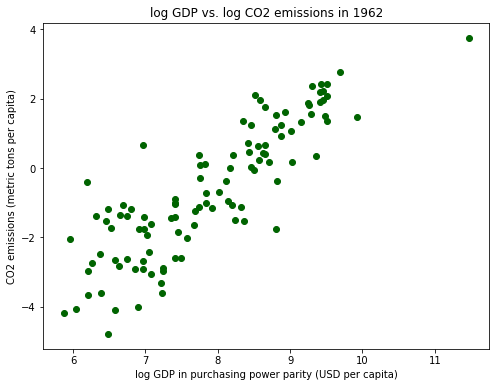

In [23]:
plt.figure(figsize=(8, 6))
plt.scatter(np.log(gdp), np.log(co2), c='darkgreen')
plt.ylabel('CO2 emissions (metric tons per capita)')
plt.xlabel('log GDP in purchasing power parity (USD per capita)')
plt.title('log GDP vs. log CO2 emissions in 1962')
plt.show()

#### Question 3 
While both variables are normally distributed, we cannot use Pearson's correlation to measure the strength of association between the two variables, because the there is outlier in the log GDP. Pearson's correlation is sensitive to outliers, so using it may result in a spurious association between the x and y variables. 

Instead, we use Kendall's Tau Coefficient correlation method, because the data meets the following assumptions: 
1. Pairs of observations are independent.
2. The two variables are on a interval scale.
3. The relationship between the two variables are monotonic, that is the direction of the relationship is consistent. 

In [24]:
# without log transforming the data,
# the data will not be normally distributed
# check for normality of data
pd.concat([pg.normality(np.log(gdp), method='normaltest'),
           pg.normality(np.log(co2), method='normaltest')])

,W,pval,normal
gdpPercap,3.059715,0.216567,True
CO2 emissions (metric tons per capita),2.519952,0.283661,True


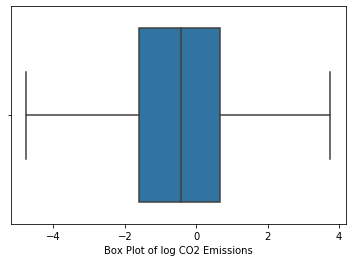

In [25]:
fig, ax = plt.subplots()
ax = sns.boxplot(np.log(co2))
ax.set_xlabel('Box Plot of log CO2 Emissions')
plt.show()

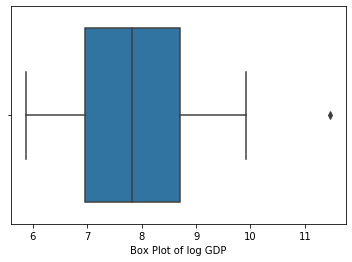

In [26]:
fig2, ax2 = plt.subplots()
ax2 = sns.boxplot(np.log(gdp))
ax2.set_xlabel('Box Plot of log GDP')
plt.show()

In [27]:
pg.corr(np.log(gdp), np.log(co2), method='kendall')

,n,r,CI95%,p-val,power
kendall,108,0.665974,"[0.55, 0.76]",1.685232e-24,1.0


What is the Kendall's Tau-b value and the associated p value?   

The correlation coefficient is 0.66 which indicates the strength of the relationship between the two variables. Log GDP is positively associated with log CO2 at tau=0.66.

#### Question 4
Kendall's Tau correlation between CO2 emissions and GDP per capita is the highest during year 2002, at r=0.78. 

In [28]:
yrs = list(df['Year'].value_counts().index)
ls = []
for y in yrs:
    a = df.loc[np.where((df['Year'] == y))]
    c = pg.corr(a['CO2 emissions (metric tons per capita)'],
                a['gdpPercap'], method='kendall')
    c['year'] = y
    c['pval'] = c['p-val'].round(4)
    ls.append(c)
corr = pd.concat(ls)
# select only significant correlations aka p-val <0.05
# and sort by strength of correlation
sig = corr[corr['p-val'] < 0.05]
sig.sort_values(by=['r'], ascending=False).head(1)

,n,r,CI95%,p-val,power,year,pval
kendall,125,0.780129,"[0.7, 0.84]",4.366385e-38,1.0,2002,0.0


#### Question 5
The interactive plot below indicates the log GDP per capita (x axis) and the log CO2 in metric tons per capita (y axis). The size of the dots correspond to the population size of the country. 

In [57]:
yr67 = df[df['Year'] == 1967]
yr67 = yr67[[
    "gdpPercap", "CO2 emissions (metric tons per capita)",
    'pop', 'continent']].dropna()
yr67[["gdpPercap",
      "CO2 emissions (metric tons per capita)"]] = np.log(
    yr67[["gdpPercap",
          "CO2 emissions (metric tons per capita)"]])

fig = px.scatter(
    yr67, x="gdpPercap",  y="CO2 emissions (metric tons per capita)",
    color="continent", size='pop',
    labels={
        "gdpPercap": "log GDP Per Capita",
        "CO2 emissions (metric tons per capita)":
        "log CO2 emissions (metric tons per capita)",
        "continent": "Continent"})

fig.update_layout(
    title={'text':'log GDP vs. log CO2 emissions in 1967',
           'xanchor': 'center', 'yanchor': 'top', 
           'x':0.45, 'y':0.92})

fig.update_traces(marker=dict(
        size=yr67['pop'],
        sizemode='area',
        sizeref=2 * max(yr67['pop']) / (80 ** 2),
        sizemin=4), selector=dict(type='scatter'))

fig.write_html("q5plot.html")
fig.show()

### More Questions
#### Question 1
What is the relationship between between continent and 'Energy use (kg of oil equivalent per capita)'

We use the Kruskal-Wallis test because it is a non-parametric version of ANOVA. It does not assume normal distribution of residuals
The test works on 2 or more independent samples, which may have different sizes.

In [30]:
mod = pg.kruskal(
    data=df, between='continent',
    dv='Energy use (kg of oil equivalent per capita)')
mod

,Source,ddof1,H,p-unc
Kruskal,continent,4,318.676317,1.012404e-67


#### Question 2
Is there a significant difference between Europe and Asia with respect to 'Imports of goods and services (% of GDP)' in the years after 1990?
We fit a linear regression model to compare the two groups. 

There is no significant difference between Europe and Asia with respect to the amount of imports of goods and services in terms percentage of GDP (p<0.05).  

While there are many candidate statistical tests we could use to compare the difference in the variable of interest between two groups, a simple linear regression is chosen, because: 
1. We can find out to what extent does the regressor (continent type) affects the regressand (imports of goods and services in terms of % of GDP). 
2. The null hypothesis is whether b1=0, where variable `Continent` = 1 if Europe, = 0 if Asia. 
y_hat = b0 + b1*`Continent`

In other words, the hypothesis is whether the parameter estimate, b1, for (Europe)−(Asia) significantly non-zero?

The confidence interval of b1 below captures the value of 0 (i.e., -13.1 to 3.4), so there is no difference between the groups (p<0.5).  

A t-test would have also provided us the answer to the question above; linear regression provides the additional advantage of informing us to what extent a change from Asia=0 to Europe=1 affect outcome variable (imports of goods and services in terms of % of GDP), which is indicated by the beta weight, -4.88.

In [31]:
df90 = df.loc[np.where((df['Year'] > 1990))]
df90 = df90[df90['continent'].isin(['Europe', 'Asia'])]
df90 = df90.replace({'Europe':1, 'Asia': 0}) #get dummy variable for categorical vars
df90 = df90.dropna()
mod = pg.linear_regression(
    df90['continent'],
    df90['Imports of goods and services (% of GDP)'].to_numpy())
mod['pval'] = mod['pval'].round(4)
mod

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,46.474503,3.202656,14.511238,0.000,0.007808,0.001972,40.152406,52.796600
1,continent,-4.882679,4.221404,-1.156648,0.249,0.007808,0.001972,-13.215801,3.450443


#### Question 3
What is the country (or countries) that has the highest 'Population density (people per sq. km of land area)' across all years? (i.e., which country has the highest average ranking in this category across each time point in the dataset?

The highest-rank country in terms of population density changes across the years, as we can tell from the graph below.   

To find out which country has the highest averaged ranking, we take the average of their ranks across the years based on their population density. Macao and Monaco are tied at the first place because their averaged ranking across the period 1962-2007 is the same.

In [32]:
var = 'Population density (people per sq. km of land area)'
g = df[[var, 'Country Name', 'Year']].groupby('Year', group_keys=False)
res = g.apply(
    lambda x: x.sort_values(
        by=[var], ascending=False).head(5))
res['rank'] = pd.DataFrame(pd.concat(
                [pd.Series([1, 2, 3, 4, 5])] * (10),
                ignore_index=True)).set_index(res.index)
avgRanking = res.groupby('Country Name').agg({'rank':'mean'}).sort_values(by=['rank'])
avgRanking

,rank
Country Name,
"Macao SAR, China",1.5
Monaco,1.5
"Hong Kong SAR, China",3.1
Singapore,3.9
Gibraltar,5.0


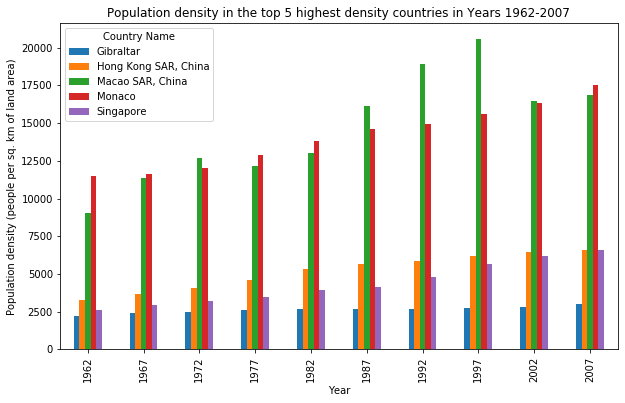

In [33]:
# Pivot the DF so that there's a column for each country, each row
# represents a year, and the cells have the population density for the
# respective year and country 
pivotDf = pd.pivot_table(
    res,
    values=var,
    index="Year",
    columns="Country Name"
)
pivotDf.plot(kind="bar",figsize=(10, 6))
plt.ylabel('Population density (people per sq. km of land area)')
plt.xlabel('Year')
plt.title('Population density in the top 5 highest density countries in Years 1962-2007')
plt.show()

### Question 4
What country (or countries) has shown the greatest increase in 
'Life expectancy at birth, total (years)' since 1962?

The top 10 countries that has shown the greatest increase in life expectancy are:  
'Maldives', 'Bhutan', 'Timor-Leste', 'Tunisia', 'Oman', 'Nepal', 'China', 'Yemen, Rep.', 'Saudi Arabia', 'Iran, Islamic Rep.'

This answer is based on the **absolute difference** in life expectancy between year 2007 and year 1962. 

In [34]:
# What country (or countries) has shown the greatest increase
# in 'Life expectancy at birth, total (years)' since 1962
var = 'Life expectancy at birth, total (years)'
g = df[[var, 'Country Name', 'Year']].groupby('Year', group_keys=False)
filteredDf = pd.concat([g.filter(lambda x : pd.Series([2007]).isin(x['Year']).all()),
             g.filter(lambda x : pd.Series([1962]).isin(x['Year']).all())])
pivotDf = filteredDf.pivot(
        index='Country Name',
        values=var,
        columns='Year').dropna()
pivotDf['diff'] = pivotDf[2007] - pivotDf[1962]
pivotDf = pivotDf.sort_values(by=['diff'],ascending=False).head(10)


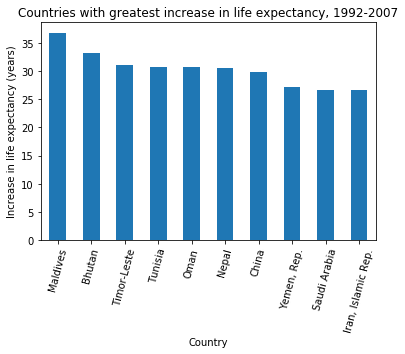

In [35]:
pivotDf.head(10).plot(kind='bar', y='diff', legend=False)
plt.title('Countries with greatest increase in life expectancy, 1992-2007')
plt.ylabel('Increase in life expectancy (years)')
plt.xlabel('Country')
plt.xticks(rotation=75)
plt.show()